# Optimal orientation for a module

Here we will undergo some basic data processing for each zipcode as follow:

## Timestamp alignment and PV components pivoting

Now, we look at the data with a specific zipcode. We need to read timestamp originally in UTC time, convert it as local time, and adjust data to align with 00, 15, 30, 45 minute marks. One can pivot timeseries data into a table where rows represent timestamps and columns represent PV component IDs. 

In [94]:
#specify data source 
datasource = 'L'

In [95]:
#specify zipcode (along with latitude, longitue, and timezone).
#[zipcode, latitude, longitude, localtz] = ['08640', 40.0039, -74.6178, 'US/Eastern']
#[zipcode, latitude, longitude, localtz] = ['08641', 40.0449, -74.5892, 'US/Eastern']
[zipcode, latitude, longitude, localtz] = ['92562', 33.5686, -117.2530, 'US/Pacific']
#[zipcode, latitude, longitude, localtz] = ['92563', 33.5712, -117.1540, 'US/Pacific']

In [96]:
#import required modules
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
#from datetime import datetime, tzinfo, dat
import datetime
#from pytz import timezone
import pytz
from pytz import timezone
import pickle #for quick read/write list
import math

#plotting in Notebook
%matplotlib inline

In [97]:
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25}
matplotlib.rc('font', **font)

## Scope and sun's altitude selection

Here we would like to data selection based on altitude of the sun. Here we coonstruct a data table with timestamp span matches our data set. This table should contain sun's altitude and azimuth angle. We may merge this table to our data table and select  only readings when the sun is up (altitude $>0$).

In [98]:
#specify scope
StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

In [99]:
#Generate data frame from start to end, along with altitude and azimuth
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal','altitude','azimuth'])
Scope['tsLocal'] = tslist

#need to install Pysolar in command prompt 'pip install Pysolar' first
import Pysolar
Scope['altitude'] = Scope.tsLocal.map(lambda x: Pysolar.GetAltitude(latitude, longitude, 
                                                                    timezone(localtz).localize(x).astimezone(pytz.utc)))

#Consider only when the sun's altitude is high.
Scope = Scope[Scope.altitude>0]
Scope['azimuth'] = Scope.tsLocal.map(lambda x: Pysolar.GetAzimuth(latitude, longitude, 
                                                                    timezone(localtz).localize(x).astimezone(pytz.utc)))
#covert to string to easy handling
#Scope['tsLocal'] = Scope.tsLocal.map(lambda x: x.strftime("%Y-%m-%d %H:%M:%S")) 


## Clear-sky solar irradiance components

In this analysis, we will use very simple model called Daneshyar-Paltridge-Proctor (DPP) model

$DNI = 950.2(1-\exp(-0.075(90^\circ-z)))$

$DHI = 14.29+21.04(\frac{\pi}{2}-z\frac{\pi}{180})$

$GHI = DNI \cos(z) + DHI$

where $z = 90 - \text{altitude}$ is zenith angle in degrees.
 

In [100]:
Scope['DNI'] = Scope.altitude.map(lambda x: 950.2*(1-math.exp(-0.075*x)))
Scope['DHI'] = 14.29+21.04*(Scope['altitude']*math.pi/180)
Scope['GHI'] = Scope['DNI']*Scope.altitude.map(lambda x: math.cos((90-x)*math.pi/180)) + Scope['DHI']

In [101]:
Scope[:5]

,tsLocal,altitude,azimuth,DNI,DHI,GHI
28,2014-01-01 07:00:00,0.782355,-298.208588,54.150292,14.577294,15.316675
29,2014-01-01 07:15:00,3.308451,-300.327492,208.801180,15.504920,27.555102
30,2014-01-01 07:30:00,5.899275,-302.526364,339.731398,16.456316,51.373892
31,2014-01-01 07:45:00,8.462668,-304.813660,446.504247,17.397638,83.107419
32,2014-01-01 08:00:00,10.968786,-307.197892,532.813132,18.317928,119.698515


## POA solar irradiance and insolation over a year

In [102]:
#define tilt and azimutgh of an array
array_tilt = 0
array_azimuth = 0

#define albedo to be = 0.2 (urban)
albedo = 0.2

CalTable = Scope

CalTable['cosAOI'] = CalTable.altitude.map(lambda x: math.cos((90-x)*math.pi/180))*math.cos(array_tilt*math.pi/180)+\
                    CalTable.altitude.map(lambda x: math.sin((90-x)*math.pi/180))*math.sin(array_tilt*math.pi/180)*\
                    CalTable.azimuth.map(lambda x: math.cos((x-array_azimuth)*math.pi/180))
        
CalTable['I_beam'] = CalTable['DNI']*CalTable['cosAOI']
CalTable['I_ground'] = CalTable['GHI']*albedo*(1-math.cos(array_tilt*math.pi/180))/2

#Use simplest model: isotropic sky
CalTable['I_diffuse'] = CalTable['DHI']*(1+math.cos(array_tilt*math.pi/180))/2

CalTable['I_POA'] = CalTable['I_beam'] + CalTable['I_ground'] + CalTable['I_diffuse']

                    

In [103]:
CalTable[:5]

,tsLocal,altitude,azimuth,DNI,DHI,GHI,cosAOI,I_beam,I_ground,I_diffuse,I_POA
28,2014-01-01 07:00:00,0.782355,-298.208588,54.150292,14.577294,15.316675,0.013654,0.739381,0,14.577294,15.316675
29,2014-01-01 07:15:00,3.308451,-300.327492,208.801180,15.504920,27.555102,0.057711,12.050182,0,15.504920,27.555102
30,2014-01-01 07:30:00,5.899275,-302.526364,339.731398,16.456316,51.373892,0.102780,34.917576,0,16.456316,51.373892
31,2014-01-01 07:45:00,8.462668,-304.813660,446.504247,17.397638,83.107419,0.147165,65.709781,0,17.397638,83.107419
32,2014-01-01 08:00:00,10.968786,-307.197892,532.813132,18.317928,119.698515,0.190274,101.380588,0,18.317928,119.698515


In [104]:
np.sum(CalTable['I_POA'])*15/60/1000 #This is insolation over a year. The unit is now kWh/m^2/year

2113.0525104111193

## Search for optimal orientation: maximizing insolation over a year

Let's vary array's tilt angle from 0 to 90 degrees and array's azimuth angle from 0 to 360 degrees. Then we can further investigate by zooming in. 

In [105]:
def InsolationOverYear(array_tilt, array_azimuth):
    CalTable = Scope

    CalTable['cosAOI'] = CalTable.altitude.map(lambda x: math.cos((90-x)*math.pi/180))*math.cos(array_tilt*math.pi/180)+\
                    CalTable.altitude.map(lambda x: math.sin((90-x)*math.pi/180))*math.sin(array_tilt*math.pi/180)*\
                    CalTable.azimuth.map(lambda x: math.cos((x-array_azimuth)*math.pi/180))
    
    #Screen negative value out
    CalTable['cosAOI'] = 0 + CalTable['cosAOI']*( CalTable['cosAOI']>=0) 
    
    #Divide by 1000 into kilo unit    
    CalTable['I_beam'] = CalTable['DNI']*CalTable['cosAOI']/1000
    CalTable['I_ground'] = CalTable['GHI']*albedo*(1-math.cos(array_tilt*math.pi/180))/2/1000

    #Use simplest model: isotropic sky
    CalTable['I_diffuse'] = CalTable['DHI']*(1+math.cos(array_tilt*math.pi/180))/2/1000

    CalTable['I_POA'] = CalTable['I_beam'] + CalTable['I_ground'] + CalTable['I_diffuse']
    return np.sum(CalTable['I_POA'])*15/60, CalTable
    

In [164]:
#For general colormap
[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-180, 180, 0, 90]
#For specific search
#[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-5, 5, 30, 32]

InsolationTable = pd.DataFrame(0, index = np.arange(81), columns = ['array_tilt','array_azimuth','insolation'])

InsolationTable['array_tilt'] =  [1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9]
    
InsolationTable['array_tilt'] = array_tilt_start + (array_tilt_end - array_tilt_start)/10.0*InsolationTable['array_tilt']
InsolationTable['array_azimuth'] = [1,1,1,1,1,1,1,1,1,
                                 2,2,2,2,2,2,2,2,2,
                                 3,3,3,3,3,3,3,3,3,
                                 4,4,4,4,4,4,4,4,4,
                                 5,5,5,5,5,5,5,5,5,
                                 6,6,6,6,6,6,6,6,6,
                                 7,7,7,7,7,7,7,7,7,
                                 8,8,8,8,8,8,8,8,8,
                                 9,9,9,9,9,9,9,9,9]
InsolationTable['array_azimuth'] = array_azimuth_start + (array_azimuth_end - array_azimuth_start)/10.0*\
                                    InsolationTable['array_azimuth']

                                 

In [165]:
for i in InsolationTable.index:
    InsolationTable.loc[i,'insolation'], CalTable = InsolationOverYear( InsolationTable['array_tilt'][i], 
                                                          InsolationTable['array_azimuth'][i])
    

Let's use a simple conversion to power. Suppose we want energy production from a 1 kW cell. Assume that the energy produced is proportional to insolation. Then we can say that InsolationTable indeed gives the correct shape and scaling.

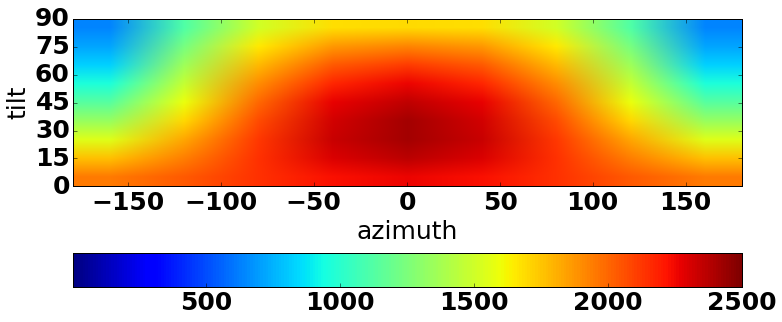

In [166]:
#For thesis, color map of insolation value
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)
#ax.set_title('colorMap')
extent = [array_azimuth_start, array_azimuth_end, array_tilt_start, array_tilt_end]

plt.imshow(np.flipud(np.transpose(np.array(InsolationTable.insolation).reshape((9, 9))))
           ,extent = extent, vmin=0,vmax=2500)
#ax.set_aspect(0.008)
ax.set_xlabel('azimuth')
ax.set_ylabel('tilt')
ax.set_yticks([0,15,30,45,60,75,90])
#ticks=np.arange(-1,2,1)
#ax.set_xticks(ticks)
'''
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
'''
plt.colorbar(orientation='horizontal',ticks = [500, 1000, 1500, 2000, 2500])
plt.show()

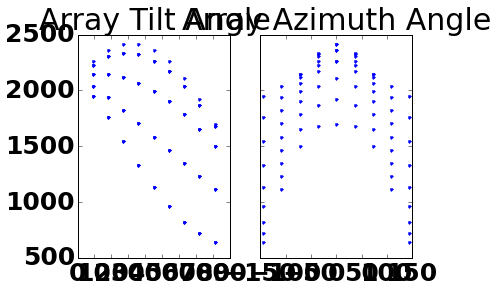

In [109]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(InsolationTable.array_tilt,InsolationTable.insolation,'.')
ax1.set_title('Array Tilt Angle')
ax2.plot(InsolationTable.array_azimuth,InsolationTable.insolation,'.')
ax2.set_title('Array Azimuth Angle')

In [110]:
InsolationTable[InsolationTable.array_azimuth==0]

,array_tilt,array_azimuth,insolation
36,9,0,2262.339372
37,18,0,2363.423580
38,27,0,2414.161015
39,36,0,2413.534535
40,45,0,2361.757404
41,54,0,2260.480321
42,63,0,2112.730275
43,72,0,1923.047903
44,81,0,1697.936109


In [111]:
InsolationTable[InsolationTable.array_tilt==31.4]

,array_tilt,array_azimuth,insolation


From here, the optimal azimuth is 0 degrees and the optimal tilt is $31.3 \pm 0.1$ degrees.

Now, let's look at sensitivity at optimal point.

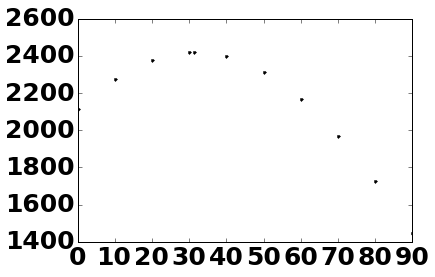

In [112]:
#varying the tilt
for i in [0,10,20,30,40,50,60,70,80,90,31.3]:
    c, d = InsolationOverYear(i, 0)
    plt.plot(i,c,'.',color='black')

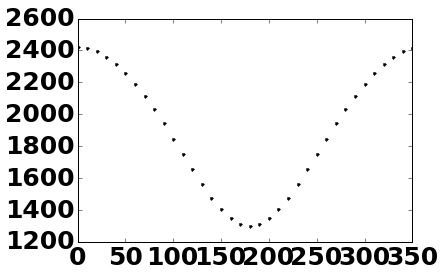

In [113]:
#varying the azimuth
for i in range(0,360,10):
    c, d = InsolationOverYear(31.3, i)
    plt.plot(i,c,'.',color='black')

Now let's look at an daily irradiance curve on summer solstice of 2013 starting at optimal. varying tilt then azimuth.

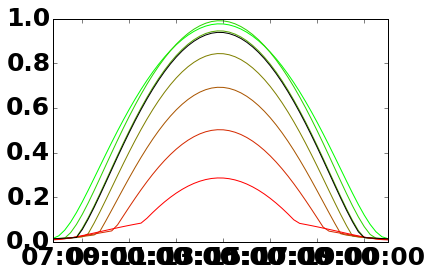

In [114]:
for i in [0,15,30,45,60,75,90]:
    c, d = InsolationOverYear(i, 0)
    dayplot = d[d.tsLocal.map(lambda x: x.date())==datetime.date(2014,6,20)]
    plt.plot(dayplot.tsLocal,dayplot.I_POA,color=(i/90.,1-i/90.,0))
    
c, d = InsolationOverYear(31.3, 0)
dayplot = d[d.tsLocal.map(lambda x: x.date())==datetime.date(2014,6,20)]
plt.plot(dayplot.tsLocal,dayplot.I_POA,color='black')

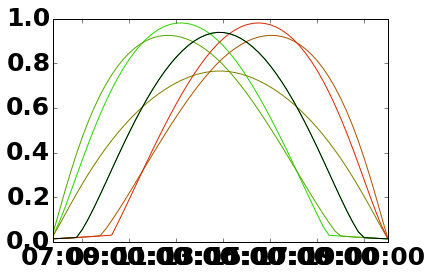

In [115]:
for i in range(0,360,60):
    c, d = InsolationOverYear(31.3, i)
    dayplot = d[d.tsLocal.map(lambda x: x.date())==datetime.date(2014,6,20)]
    plt.plot(dayplot.tsLocal,dayplot.I_POA,color=(i/360.,1-i/360.,0))
    
c, d = InsolationOverYear(31.3, 0)
dayplot = d[d.tsLocal.map(lambda x: x.date())==datetime.date(2014,6,20)]
plt.plot(dayplot.tsLocal,dayplot.I_POA,color='black')

For CA, the rule of thumb ("tilt angle = latitude") works pretty well. The insolation differs from the maximum by about 0.06 percent

In [116]:
c1,d1= InsolationOverYear(latitude,0)
c2,d2= InsolationOverYear(31.3,0)
(1-c1/c2)*100

0.062210595694589532

## Search for optimal orientation: minimizing peak (?)

Consider a fix penetration: 15% rule. Capacity equal to 15% peak load of the year. Assume STU condition.

In [117]:
#specify data source 
#datasource = 'PJM'
#filename = 'pjm_e_load_data_2012.csv'
#datasource = 'CAISO/raw/caiso_load_data_2013'
datasource = 'CAISO/raw/caiso_load_data_2014'
#filename = 'caiso_north_load_data_2012.csv'

#timezone for local time adjustment
localtz = 'US/Pacific'

#specific to CAISO data
TacName = 'Caiso_Totals'#'TAC_NORTH'

mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
dataDir = mainDir + '/data/load/' + datasource +'/'
#outputDir = mainDir + '/output/'+ datasource +'/'

d01 = pd.read_csv(dataDir +'/'+ '01.csv')
d01 = d01[d01['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d02 = pd.read_csv(dataDir +'/'+ '02.csv')
d02 = d02[d02['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d03 = pd.read_csv(dataDir +'/'+ '03.csv')
d03 = d03[d03['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d04 = pd.read_csv(dataDir +'/'+ '04.csv')
d04 = d04[d04['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d05 = pd.read_csv(dataDir +'/'+ '05.csv')
d05 = d05[d05['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d06 = pd.read_csv(dataDir +'/'+ '06.csv')
d06 = d06[d06['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d07 = pd.read_csv(dataDir +'/'+ '07.csv')
d07 = d07[d07['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d08 = pd.read_csv(dataDir +'/'+ '08.csv')
d08 = d08[d08['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d09 = pd.read_csv(dataDir +'/'+ '09.csv')
d09 = d09[d09['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d10 = pd.read_csv(dataDir +'/'+ '10.csv')
d10 = d10[d10['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d11 = pd.read_csv(dataDir +'/'+ '11.csv')
d11 = d11[d11['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')
d12 = pd.read_csv(dataDir +'/'+ '12.csv')
d12 = d12[d12['TAC_ZONE_NAME']==TacName].sort(columns='INTERVALSTARTTIME_GMT')

data = pd.concat([d01,d02,d03,d04,d05,d06,d07,d08,d09,d10,d11,d12])

data['tsLocal'] = data['INTERVALSTARTTIME_GMT'].map(lambda x: datetime.datetime.strptime(x[0:19],"%Y-%m-%dT%H:%M:%S").replace(tzinfo=pytz.utc)\
                            .astimezone(pytz.timezone(localtz)).strftime("%Y-%m-%d %H:%M:%S"))
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

data = data[['tsLocal','MW']].reset_index().drop(['index'],1)
data.columns = ['tsLocal','load']
#delete double readings (can happen due to daylight savings)
data = data.groupby(['tsLocal']).mean().reset_index()
loaddata = data

In [118]:
loaddata[loaddata['load'] == np.max(loaddata['load'])]

,tsLocal,load
5104,2014-08-01 17:00:00,43479.84


In [119]:
loadmaxdate = loaddata[loaddata['load'] == np.max(loaddata['load'])].tsLocal.iloc[0].date()

This sets the capacity of PV installation (15%) of peak demand

In [120]:
PVsize = 0.15*np.max(loaddata['load'])

In [121]:
#scope and load integration
#specify scope

StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
    
Scope_load = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope_load['tsLocal'] = tslist

#Scope is already defined.

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope_load,loaddata,on=['tsLocal'], how = 'left') 

#Interpolate load values to 15 mins
for j in range(1,2):
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
            #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


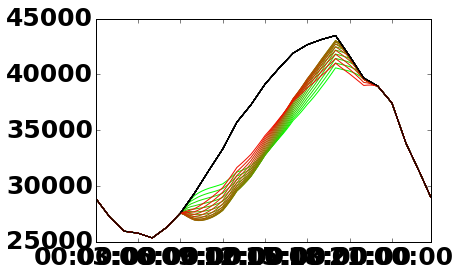

In [122]:
azimuth_angle_list = range(0,180,10)
solar_energy_list = [0]*18
peak_power_list = [0]*18

for i in azimuth_angle_list:
    #energy sum and power file 
    solar_energy,solar_power = InsolationOverYear(31.3,i)
    solar_energy_list[i/10] = solar_energy*PVsize

    #merge solar power data in
    #solar_power['tsLocal'] = solar_power['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    d_integrated = pd.merge(d,solar_power,on=['tsLocal'], how = 'left') 

    #this is PV generation from PV fleets
    d_integrated['netload'] = -d_integrated['I_POA']*PVsize
    d_integrated['netload'][d_integrated['I_POA'].isnull()] = 0
    d_integrated['netload'] = d_integrated['netload']+ d_integrated['load']
    
    peak_power_list[i/10] = np.max(d_integrated['netload'])

    #plot day with raw peak load of the year. Don't see much change.
    dayplot = d_integrated[d_integrated.tsLocal.map(lambda x: x.date()) == loadmaxdate]
    plt.plot(dayplot.tsLocal,dayplot['netload'],color=(i/180.,1-i/180.,0))
    plt.plot(dayplot.tsLocal,dayplot['load'],color='black')
    #plt.plot(dayplot.tsLocal,dayplot['I_POA'])


C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


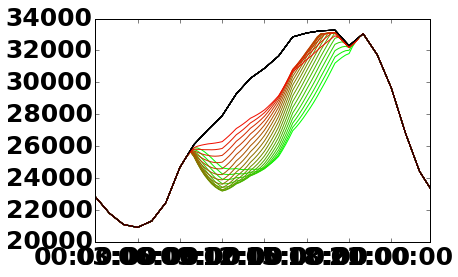

In [123]:
#Let's look at other days of the year

dayofinterest = datetime.date(2014,6,20) #peak 6 pm has some effect
dayofinterest = datetime.date(2014,1,1) #peak 6 pm no effect
dayofinterest = datetime.date(2014,4,1) #peak 7 pm no effect
dayofinterest = datetime.date(2014,10,1) #peak 7 pm no effect

azimuth_angle_list = range(0,180,10)
solar_energy_list = [0]*18
peak_power_list = [0]*18

for i in azimuth_angle_list:
    #energy sum and power file 
    solar_energy,solar_power = InsolationOverYear(31.3,i)
    solar_energy_list[i/10] = solar_energy*PVsize

    #merge solar power data in
    #solar_power['tsLocal'] = solar_power['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    d_integrated = pd.merge(d,solar_power,on=['tsLocal'], how = 'left') 

    #this is PV generation from PV fleets
    d_integrated['netload'] = -d_integrated['I_POA']*PVsize
    d_integrated['netload'][d_integrated['I_POA'].isnull()] = 0
    d_integrated['netload'] = d_integrated['netload']+ d_integrated['load']
    
    peak_power_list[i/10] = np.max(d_integrated['netload'])


    #plot day with raw peak load of the year. Don't see much change.
    dayplot = d_integrated[d_integrated.tsLocal.map(lambda x: x.date()) == dayofinterest]
    plt.plot(dayplot.tsLocal,dayplot['netload'],color=(i/180.,1-i/180.,0))
    plt.plot(dayplot.tsLocal,dayplot['load'],color='black')
    #plt.plot(dayplot.tsLocal,dayplot['I_POA'])


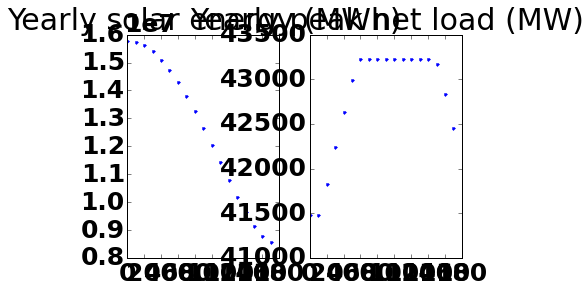

In [124]:
f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True)
ax1.plot(azimuth_angle_list,solar_energy_list,'.')
ax1.set_title('Yearly solar energy (MWh)')
ax2.plot(azimuth_angle_list,peak_power_list,'.')
ax2.set_title('Yearly peak net load (MW)')

Here one can see that minimizing peak does not work as the peak demand is not during daylight time. We need to tilt almost all the day to the west to see slight drop of the peak.

In [125]:
def PeakNetLoadOverYear(array_tilt, array_azimuth):
    
    solar_energy,solar_power = InsolationOverYear(array_tilt,array_azimuth)

    #merge solar power data in
    #solar_power['tsLocal'] = solar_power['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    d_integrated = pd.merge(d,solar_power,on=['tsLocal'], how = 'left') 

    #this is PV generation from PV fleets
    d_integrated['netload'] = -d_integrated['I_POA']*PVsize
    d_integrated['netload'][d_integrated['I_POA'].isnull()] = 0
    d_integrated['netload'] = d_integrated['netload']+ d_integrated['load']
    
    return np.max(d_integrated['netload'])
    

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


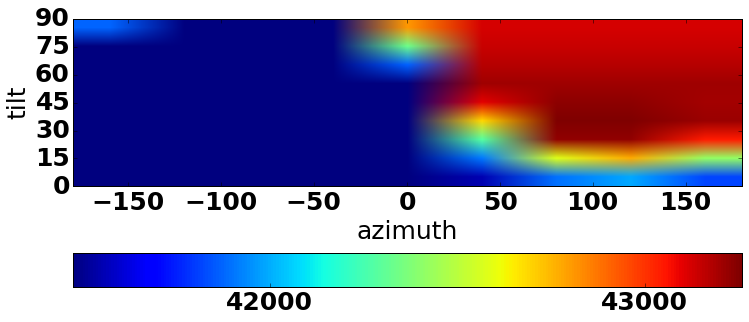

In [162]:
#For thesis, simple search
#Even though the name is Insolation, we are now looking at peak load of the year

#For general colormap
[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-180, 180, 0, 90]
#For specific search
#[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-5, 5, 30, 32]

InsolationTable = pd.DataFrame(0, index = np.arange(81), columns = ['array_tilt','array_azimuth','insolation'])

InsolationTable['array_tilt'] =  [1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9]
    
InsolationTable['array_tilt'] = array_tilt_start + (array_tilt_end - array_tilt_start)/10.0*InsolationTable['array_tilt']
InsolationTable['array_azimuth'] = [1,1,1,1,1,1,1,1,1,
                                 2,2,2,2,2,2,2,2,2,
                                 3,3,3,3,3,3,3,3,3,
                                 4,4,4,4,4,4,4,4,4,
                                 5,5,5,5,5,5,5,5,5,
                                 6,6,6,6,6,6,6,6,6,
                                 7,7,7,7,7,7,7,7,7,
                                 8,8,8,8,8,8,8,8,8,
                                 9,9,9,9,9,9,9,9,9]
InsolationTable['array_azimuth'] = array_azimuth_start + (array_azimuth_end - array_azimuth_start)/10.0*\
                                    InsolationTable['array_azimuth']

#Change the objective here. 
for i in InsolationTable.index:
    InsolationTable.loc[i,'insolation'] = PeakNetLoadOverYear( InsolationTable['array_tilt'][i], 
                                                          InsolationTable['array_azimuth'][i])

#For thesis, color map of insolation value
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)
#ax.set_title('colorMap')
extent = [array_azimuth_start, array_azimuth_end, array_tilt_start, array_tilt_end]

plt.imshow(np.flipud(np.transpose(np.array(InsolationTable.insolation).reshape((9, 9))))
           ,extent = extent, vmin=np.min(InsolationTable.insolation),vmax=np.max(InsolationTable.insolation))
#ax.set_aspect(0.008)
ax.set_xlabel('azimuth')
ax.set_ylabel('tilt')
ax.set_yticks([0,15,30,45,60,75,90])
#ticks=np.arange(-1,2,1)
#ax.set_xticks(ticks)
'''
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
'''
plt.colorbar(orientation='horizontal',ticks = [41000, 42000, 43000])
plt.show()
                                 


In [127]:
InsolationTable[InsolationTable.insolation==np.min(InsolationTable.insolation)]

,array_tilt,array_azimuth,insolation
0,9,-144,41474.76
1,18,-144,41474.76
2,27,-144,41474.76
3,36,-144,41474.76
4,45,-144,41474.76
5,54,-144,41474.76
6,63,-144,41474.76
7,72,-144,41474.76
9,9,-108,41474.76
10,18,-108,41474.76


## Search for optimal orientation: minimizing quadratic cost of generation

Assume same level of penetration. Now try to minimize quadratic cost of generation instead. That is, try to minimize sum of net load squared.

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


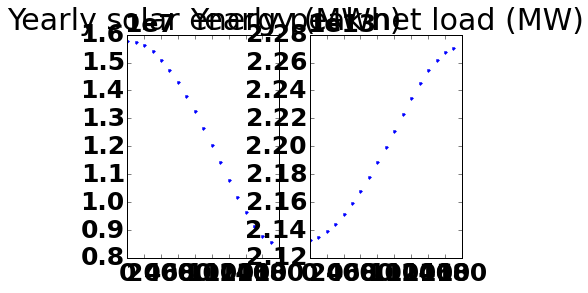

In [128]:
azimuth_angle_list = range(0,180,10)
solar_energy_list = [0]*18
cost_generation_list = [0]*18

for i in azimuth_angle_list:
    #energy sum and power file 
    solar_energy,solar_power = InsolationOverYear(31.3,i)
    solar_energy_list[i/10] = solar_energy*PVsize

    #merge solar power data in
    #solar_power['tsLocal'] = solar_power['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    d_integrated = pd.merge(d,solar_power,on=['tsLocal'], how = 'left') 

    #this is PV generation from PV fleets
    d_integrated['netload'] = -d_integrated['I_POA']*PVsize
    d_integrated['netload'][d_integrated['I_POA'].isnull()] = 0
    d_integrated['netload'] = d_integrated['netload']+ d_integrated['load']
    
    cost_generation_list[i/10] = np.sum(d_integrated['netload']*d_integrated['netload'])

f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True)
ax1.plot(azimuth_angle_list,solar_energy_list,'.')
ax1.set_title('Yearly solar energy (MWh)')
ax2.plot(azimuth_angle_list,cost_generation_list,'.')
ax2.set_title('Yearly peak net load (MW)')
   


Let's now search for all possible tilt and azimuth.

In [129]:
def GenerationCostOverYear(array_tilt, array_azimuth):
    
    solar_energy,solar_power = InsolationOverYear(array_tilt,array_azimuth)

    #merge solar power data in
    #solar_power['tsLocal'] = solar_power['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    d_integrated = pd.merge(d,solar_power,on=['tsLocal'], how = 'left') 

    #this is PV generation from PV fleets
    d_integrated['netload'] = -d_integrated['I_POA']*PVsize
    d_integrated['netload'][d_integrated['I_POA'].isnull()] = 0
    d_integrated['netload'] = d_integrated['netload']+ d_integrated['load']
    
    return np.sum(d_integrated['netload']*d_integrated['netload'])
    

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


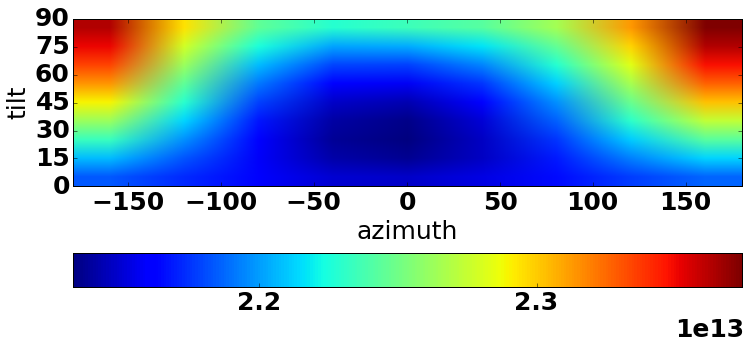

In [161]:
#For thesis, simple search
#Even though the name is Insolation, we are now looking at peak load of the year

#For general colormap
[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-180, 180, 0, 90]
#For specific search
#[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-5, 5, 30, 32]

InsolationTable = pd.DataFrame(0, index = np.arange(81), columns = ['array_tilt','array_azimuth','insolation'])

InsolationTable['array_tilt'] =  [1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9]
    
InsolationTable['array_tilt'] = array_tilt_start + (array_tilt_end - array_tilt_start)/10.0*InsolationTable['array_tilt']
InsolationTable['array_azimuth'] = [1,1,1,1,1,1,1,1,1,
                                 2,2,2,2,2,2,2,2,2,
                                 3,3,3,3,3,3,3,3,3,
                                 4,4,4,4,4,4,4,4,4,
                                 5,5,5,5,5,5,5,5,5,
                                 6,6,6,6,6,6,6,6,6,
                                 7,7,7,7,7,7,7,7,7,
                                 8,8,8,8,8,8,8,8,8,
                                 9,9,9,9,9,9,9,9,9]
InsolationTable['array_azimuth'] = array_azimuth_start + (array_azimuth_end - array_azimuth_start)/10.0*\
                                    InsolationTable['array_azimuth']

#Change the objective here. 
for i in InsolationTable.index:
    InsolationTable.loc[i,'insolation'] = GenerationCostOverYear( InsolationTable['array_tilt'][i], 
                                                          InsolationTable['array_azimuth'][i])

#For thesis, color map of insolation value
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)
#ax.set_title('colorMap')
extent = [array_azimuth_start, array_azimuth_end, array_tilt_start, array_tilt_end]

plt.imshow(np.flipud(np.transpose(np.array(InsolationTable.insolation).reshape((9, 9))))
           ,extent = extent, vmin=np.min(InsolationTable.insolation),vmax=np.max(InsolationTable.insolation))
#ax.set_aspect(0.008)
ax.set_xlabel('azimuth')
ax.set_ylabel('tilt')
ax.set_yticks([0,15,30,45,60,75,90])
#ticks=np.arange(-1,2,1)
#ax.set_xticks(ticks)
'''
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
'''
plt.colorbar(orientation='horizontal',ticks = [2.1e13, 2.2e13, 2.3e13, 2.4e14])
plt.show()
                                 


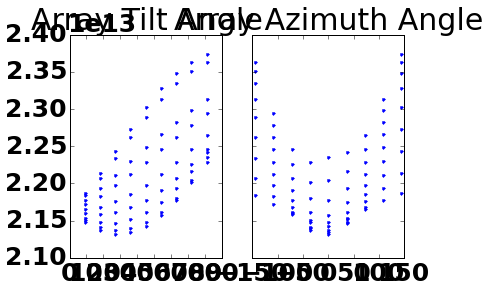

In [131]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(InsolationTable.array_tilt,InsolationTable.insolation,'.')
ax1.set_title('Array Tilt Angle')
ax2.plot(InsolationTable.array_azimuth,InsolationTable.insolation,'.')
ax2.set_title('Array Azimuth Angle')

The optimal point now drifted away from the original optimal point. Tilt is lowered. Azimuth may be negative (facing east) to help out morning peak rather than evening peak!

Rescan for accuracy

In [132]:
#For thesis, simple search
#Even though the name is Insolation, we are now looking at peak load of the year

#For general colormap
#[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-180, 180, 0, 90]
#For specific search
[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-15, -5, 28, 30]

InsolationTable = pd.DataFrame(0, index = np.arange(81), columns = ['array_tilt','array_azimuth','insolation'])

InsolationTable['array_tilt'] =  [1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9]
    
InsolationTable['array_tilt'] = array_tilt_start + (array_tilt_end - array_tilt_start)/10.0*InsolationTable['array_tilt']
InsolationTable['array_azimuth'] = [1,1,1,1,1,1,1,1,1,
                                 2,2,2,2,2,2,2,2,2,
                                 3,3,3,3,3,3,3,3,3,
                                 4,4,4,4,4,4,4,4,4,
                                 5,5,5,5,5,5,5,5,5,
                                 6,6,6,6,6,6,6,6,6,
                                 7,7,7,7,7,7,7,7,7,
                                 8,8,8,8,8,8,8,8,8,
                                 9,9,9,9,9,9,9,9,9]
InsolationTable['array_azimuth'] = array_azimuth_start + (array_azimuth_end - array_azimuth_start)/10.0*\
                                    InsolationTable['array_azimuth']

#Change the objective here. 
for i in InsolationTable.index:
    InsolationTable.loc[i,'insolation'] = GenerationCostOverYear( InsolationTable['array_tilt'][i], 
                                                          InsolationTable['array_azimuth'][i])

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


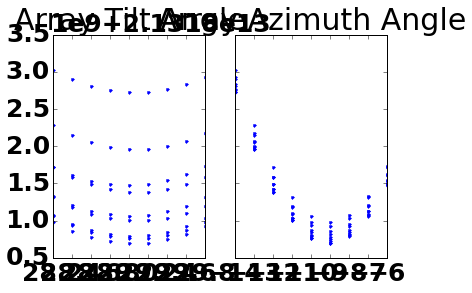

In [133]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(InsolationTable.array_tilt,InsolationTable.insolation,'.')
ax1.set_title('Array Tilt Angle')
ax2.plot(InsolationTable.array_azimuth,InsolationTable.insolation,'.')
ax2.set_title('Array Azimuth Angle')

In [134]:
InsolationTable[InsolationTable.insolation==np.min(InsolationTable.insolation)]

,array_tilt,array_azimuth,insolation
49,29,-9,2.131870e+13


The optimal angle is about $29.1 \pm 0.1$ degrees tilt and $-9.5 \pm 0.5$ degrees azimuth.

In [135]:
a1,b1=InsolationOverYear(29.1,-9.5)
a2,b2=InsolationOverYear(31.3,0)
a1, a2, 1-a1/a2

(2412.8189690244876, 2420.2858512441844, 0.0030851241046003786)

## Search for optimal orientation: minimizing quadratic cost of ramp rates

In [136]:
def RampRateCostOverYear(array_tilt, array_azimuth):
    
    solar_energy,solar_power = InsolationOverYear(array_tilt,array_azimuth)

    #merge solar power data in
    #solar_power['tsLocal'] = solar_power['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    d_integrated = pd.merge(d,solar_power,on=['tsLocal'], how = 'left') 

    #this is PV generation from PV fleets
    d_integrated['netload'] = -d_integrated['I_POA']*PVsize
    d_integrated['netload'][d_integrated['I_POA'].isnull()] = 0
    d_integrated['netload'] = d_integrated['netload']+ d_integrated['load']
    n = d_integrated.shape[0]
    l = d_integrated['netload']
    l1 = list(l[0:(n-1)])
    l2 = list(l[1:n])
    m = [0]*(n-1)
    for i in range(0,n-1):
        m[i] = (l2[i]-l1[i])*(l2[i]-l1[i])
    
    return np.nansum(m)
    

In [157]:
#For thesis, simple search
#Even though the name is Insolation, we are now looking at peak load of the year

#For general colormap
[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-180, 180, 0, 90]
#For specific search
#[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-5, 5, 30, 32]

InsolationTable = pd.DataFrame(0, index = np.arange(81), columns = ['array_tilt','array_azimuth','insolation'])

InsolationTable['array_tilt'] =  [1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9]
    
InsolationTable['array_tilt'] = array_tilt_start + (array_tilt_end - array_tilt_start)/10.0*InsolationTable['array_tilt']
InsolationTable['array_azimuth'] = [1,1,1,1,1,1,1,1,1,
                                 2,2,2,2,2,2,2,2,2,
                                 3,3,3,3,3,3,3,3,3,
                                 4,4,4,4,4,4,4,4,4,
                                 5,5,5,5,5,5,5,5,5,
                                 6,6,6,6,6,6,6,6,6,
                                 7,7,7,7,7,7,7,7,7,
                                 8,8,8,8,8,8,8,8,8,
                                 9,9,9,9,9,9,9,9,9]
InsolationTable['array_azimuth'] = array_azimuth_start + (array_azimuth_end - array_azimuth_start)/10.0*\
                                    InsolationTable['array_azimuth']

#Change the objective here. 
for i in InsolationTable.index:
    InsolationTable.loc[i,'insolation'] = RampRateCostOverYear( InsolationTable['array_tilt'][i], 
                                                          InsolationTable['array_azimuth'][i])

                                 


C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


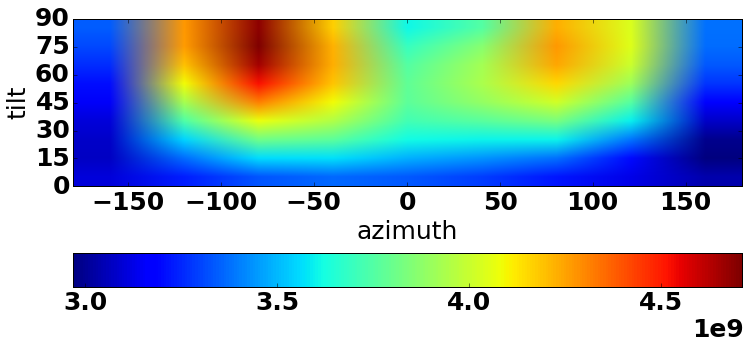

In [160]:

#For thesis, color map of insolation value
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)
#ax.set_title('colorMap')
extent = [array_azimuth_start, array_azimuth_end, array_tilt_start, array_tilt_end]

plt.imshow(np.flipud(np.transpose(np.array(InsolationTable.insolation).reshape((9, 9))))
           ,extent = extent, vmin=np.min(InsolationTable.insolation),vmax=np.max(InsolationTable.insolation))
#ax.set_aspect(0.008)
ax.set_xlabel('azimuth')
ax.set_ylabel('tilt')
ax.set_yticks([0,15,30,45,60,75,90])
#ticks=np.arange(-1,2,1)
#ax.set_xticks(ticks)
'''
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
'''
plt.colorbar(orientation='horizontal',ticks = [3e9, 3.5e9, 4.0e9, 4.5e9])
plt.show()

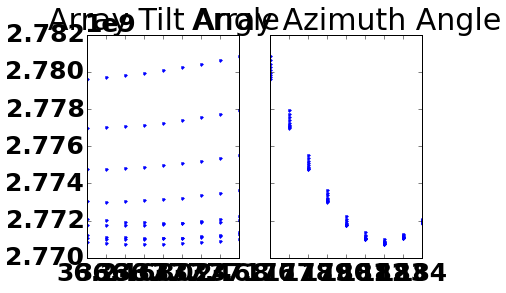

In [151]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(InsolationTable.array_tilt,InsolationTable.insolation,'.')
ax1.set_title('Array Tilt Angle')
ax2.plot(InsolationTable.array_azimuth,InsolationTable.insolation,'.')
ax2.set_title('Array Azimuth Angle')

In [140]:
#For thesis, simple search
#Even though the name is Insolation, we are now looking at peak load of the year

#For general colormap
#[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [-180, 180, 0, 90]
#For specific search
[array_azimuth_start, array_azimuth_end, array_tilt_start,array_tilt_end] = [175, 185, 36, 38]

InsolationTable = pd.DataFrame(0, index = np.arange(81), columns = ['array_tilt','array_azimuth','insolation'])

InsolationTable['array_tilt'] =  [1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9,
                                    1,2,3,4,5,6,7,8,9]
    
InsolationTable['array_tilt'] = array_tilt_start + (array_tilt_end - array_tilt_start)/10.0*InsolationTable['array_tilt']
InsolationTable['array_azimuth'] = [1,1,1,1,1,1,1,1,1,
                                 2,2,2,2,2,2,2,2,2,
                                 3,3,3,3,3,3,3,3,3,
                                 4,4,4,4,4,4,4,4,4,
                                 5,5,5,5,5,5,5,5,5,
                                 6,6,6,6,6,6,6,6,6,
                                 7,7,7,7,7,7,7,7,7,
                                 8,8,8,8,8,8,8,8,8,
                                 9,9,9,9,9,9,9,9,9]
InsolationTable['array_azimuth'] = array_azimuth_start + (array_azimuth_end - array_azimuth_start)/10.0*\
                                    InsolationTable['array_azimuth']

#Change the objective here. 
for i in InsolationTable.index:
    InsolationTable.loc[i,'insolation'] = RampRateCostOverYear( InsolationTable['array_tilt'][i], 
                                                          InsolationTable['array_azimuth'][i])

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


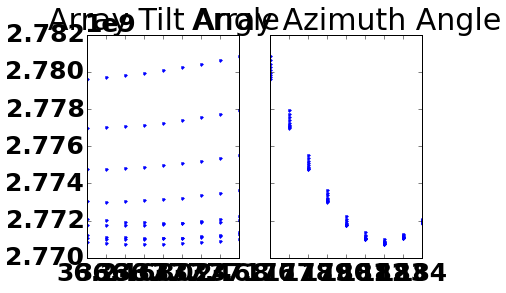

In [141]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(InsolationTable.array_tilt,InsolationTable.insolation,'.')
ax1.set_title('Array Tilt Angle')
ax2.plot(InsolationTable.array_azimuth,InsolationTable.insolation,'.')
ax2.set_title('Array Azimuth Angle')

In [142]:
InsolationTable[InsolationTable.insolation==np.min(InsolationTable.insolation)]

,array_tilt,array_azimuth,insolation
57,36.8,182,2.770756e+09


The optimal angle is about $36.8 \pm 0.1$ degrees tilt and $182 \pm 0.5$ degrees azimuth.

In [143]:
a1,b1=InsolationOverYear(36.8,182)
a2,b2=InsolationOverYear(31.3,0)
a1, a2, 1-a1/a2

(1147.8312797430058, 2420.2858512441844, 0.52574557292356783)